# Recommendation System

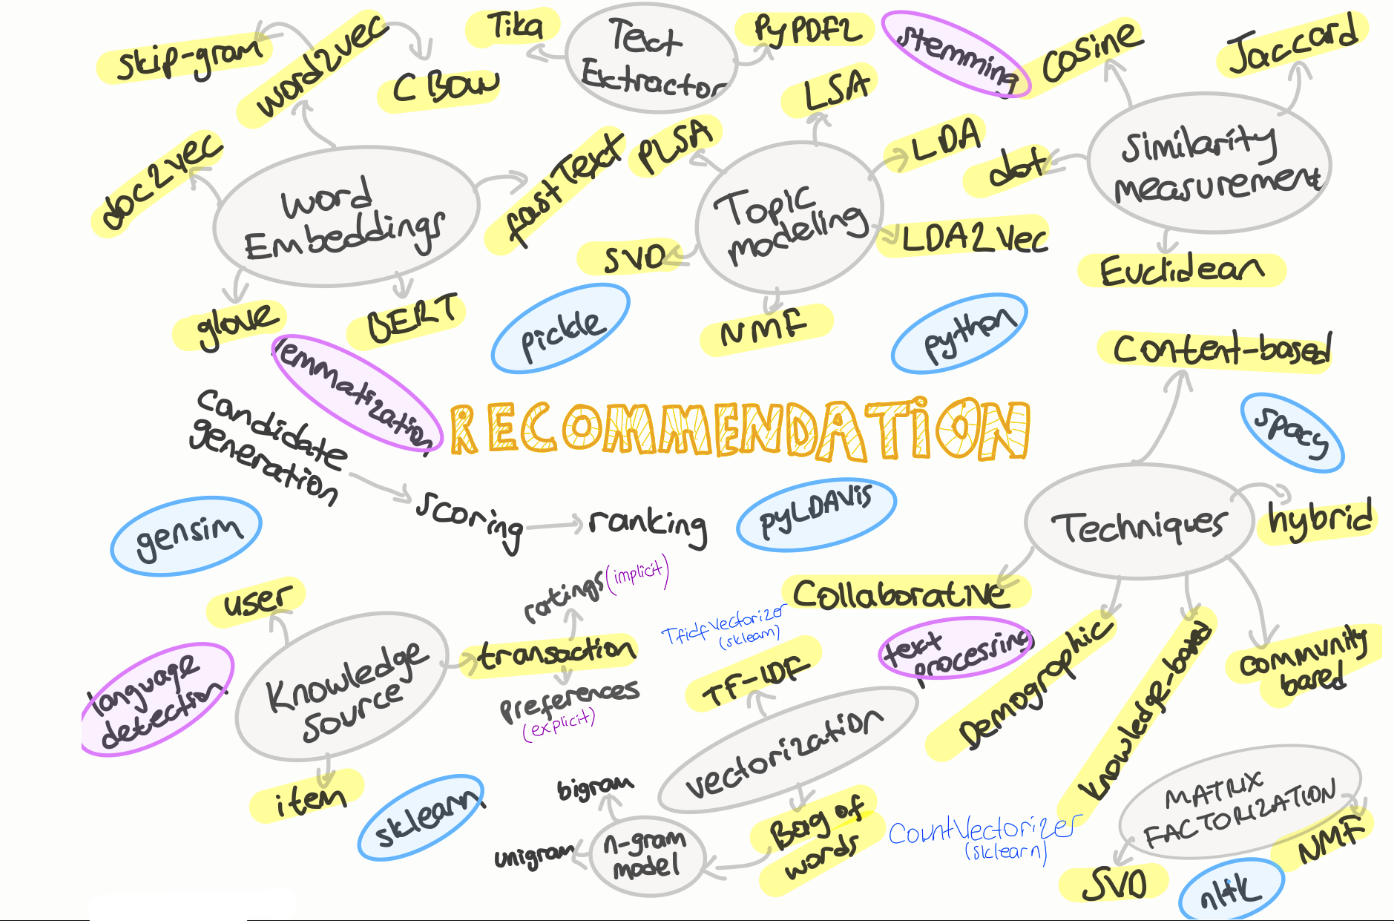

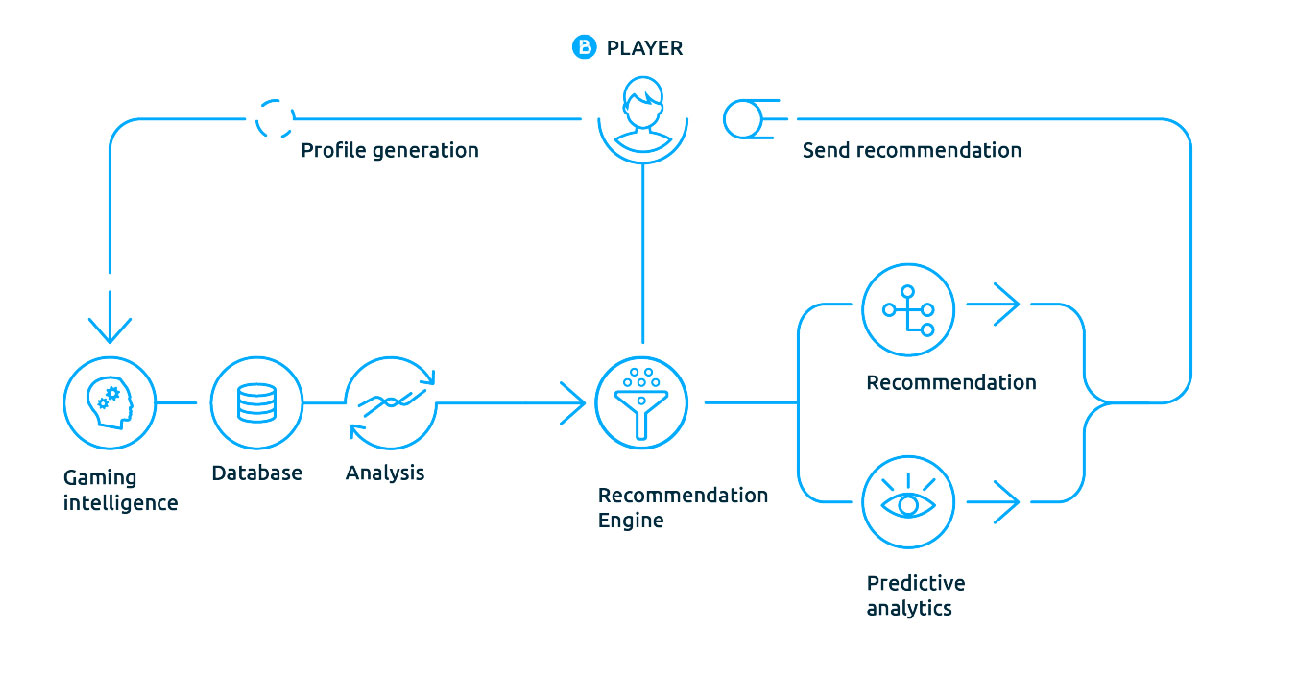

## Dataset Information

Million Songs Dataset contains of two files: 
 triplet_file and metadata_file. 

1. The triplet_file contains **User_Id, Song_Id and Listen Counts**. 

2. The metadata_file contains **Track_Id, Song_Id, Artist_Name, Title**.

Million Songs Dataset is a mixture of song from various website with the rating that users gave after listening to the song.

There are 3 types of recommendation system: content-based, collaborative and popularity.

## Important Liberaries

In [1]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
import math as mt
from scipy.sparse.linalg import * #used for matrix multiplication
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix
from scipy.stats import skew, norm, probplot
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

## Importing Data

In [2]:
from collections import defaultdict
usersDict = defaultdict(int)
with open("kaggle_visible_evaluation_triplets.txt", "r") as songFile:
    for record in songFile:
        #Fetch user id as the first item from a tab delimited line of record
        user = record.split("\t")[0]
        #Fetch song play count as the last item from a tab delimited line of record
        play_count = int(record.split("\t")[2])
        #Update song play count for a user
        usersDict[user] += play_count
        
userPlayCountList = [{'user': u, 'play_count': p} for u,p in usersDict.items()]
dfSongsPlayCount = pd.DataFrame(userPlayCountList)
#Arrange the user songs played records in descending order to facilitate further analysis
dfSongsPlayCount = dfSongsPlayCount.sort_values(by = 'play_count', ascending = False)
dfSongsPlayCount.to_csv("Final_songs_play_count.csv", index=None)

In [3]:
dfSongsPlayCount.shape

(110000, 2)

In [4]:
dfSongsPlayCount.head()

,user,play_count
93249,090b841eaf56d343a26625c2c6d08b823927bc4f,1305
42095,938c2632d43eeadb8a83a7cc254d014f9cea6afe,1267
106017,1c5aa998482a40abfd020759e7d757eb6c510e72,1200
1849,c6150292374fb1dad89982367b3245dd5004c718,1192
58514,5a9375e46a7e9b869058c7bc0e820e00d77f3e0b,1184


In [5]:
totalPlayCount = sum(dfSongsPlayCount.play_count)
(float(dfSongsPlayCount.head(n=100000).play_count.sum())/totalPlayCount)*100
dfUserSubset = dfSongsPlayCount.head(n=100000)

In [6]:
dfUserSubset=dfSongsPlayCount.copy()

In [7]:
songsDict = defaultdict(int)
with open("kaggle_visible_evaluation_triplets.txt", "r") as songFile:
    for record in songFile:
        #Fetch song id as the first item from a tab delimited line of record
        song = record.split("\t")[1]
        #Fetch song play count as the last item from a tab delimited line of record
        play_count = int(record.split("\t")[2])
        #Update song play count for a song
        songsDict[song] += play_count
        
songPlayCountList = [{'song': s, 'play_count': p} for s,p in songsDict.items()]
dfSongsPlaySummary = pd.DataFrame(songPlayCountList)
#Arrange the user songs played records in descending order to facilitate further analysis
dfSongsPlaySummary = dfSongsPlaySummary.sort_values(by = 'play_count', ascending = False)
dfSongsPlaySummary.to_csv("songs_summary.csv", index=None)

In [8]:
dfSongsPlaySummary.shape

(163206, 2)

In [9]:
dfSongPlayCountSubset=dfSongsPlaySummary.copy()

In [10]:
dfAllSongs = pd.read_csv("kaggle_visible_evaluation_triplets.txt", sep="\t", names=['user', 'song', 'play_count'], header=None)
#Filter records for top 40% users using the users subset found earlier
dfSongsTopUsers = dfAllSongs[dfAllSongs.user.isin(list(dfUserSubset.user))]
dfSongsTopSongs = dfSongsTopUsers[dfSongsTopUsers.song.isin(list(dfSongPlayCountSubset.song))]

In [11]:
dfSongsTopUsers.shape

(1450933, 3)

In [12]:
dfSongsTopSongs.shape

(1450933, 3)

In [13]:
#Save the top 30 songs dataset to a file
dfSongsTopSongs.to_csv("triplet.csv", index=False)
#Find the number of records in this subset
dfSongsTopSongs.shape

(1450933, 3)

In [14]:
triplet = pd.read_csv("triplet.csv")

In [15]:
triplet.shape

(1450933, 3)

In [16]:
unique= pd.read_csv("unique_tracks.txt",sep = "<SEP>", names = ["track","song","artist_name","title"])
unique_track = unique[unique.song.isin(list(dfSongPlayCountSubset.song))]

In [17]:
unique_track.shape

(163828, 4)

## Merging Data

In [18]:
unique_track.drop_duplicates(['song'], inplace=True)
#Join the earlier obtained top popular songs dataset and this metadata dataframe on song id
song_data = pd.merge(triplet, unique_track, how="left", 
                                      left_on="song", right_on = "song")
#Keep only relevant columns
song_data = song_data[['track','user', 'song','play_count', 'artist_name','title']]
song_data.head(3)

,track,user,song,play_count,artist_name,title
0,TRAEHHJ12903CF492F,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,Dwight Yoakam,You're The One
1,TRLGMFJ128F4217DBE,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...
2,TRTNDNE128F1486812,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1,Cartola,Tive Sim


In [19]:
print(song_data.shape[0],"Rows","&",song_data .shape[1],"Columns" )

1450933 Rows & 6 Columns


In [20]:
#triplet = pd.read_csv("top_Songs_Subset.csv")
#triplet.head(2)

## Explorartory Data Analyses

In [21]:
print("Rows, Column of unique_track data after seperation is :" ,unique_track.shape)
print("Rows, Column of triplet data after seperation is :" ,triplet.shape)

Rows, Column of unique_track data after seperation is : (163206, 4)
Rows, Column of triplet data after seperation is : (1450933, 3)


### This dataset is really large, let's see unique values in features

In [22]:
print("Unique Song ID's in song_data are:", len(song_data["song"].unique()))
print("Unique Artist Names in song_data are:", len(song_data["artist_name"].unique()))
print("Unique Titles in unique song_data are:", len(song_data["title"].unique()))

Unique Song ID's in song_data are: 163206
Unique Artist Names in song_data are: 28361
Unique Titles in unique song_data are: 137627


In [23]:
print("Unique users in song_data are:", len(song_data["user"].unique()))
print("Unique songs in song_data are:", len(song_data["song"].unique()))
print("Unique play_counts in song_data are:", len(song_data["play_count"].unique()))

Unique users in song_data are: 110000
Unique songs in song_data are: 163206
Unique play_counts in song_data are: 299


### Let's see Kernel Density Estimate which is used for visualizing the Probability Density 

1.Unique_track Data

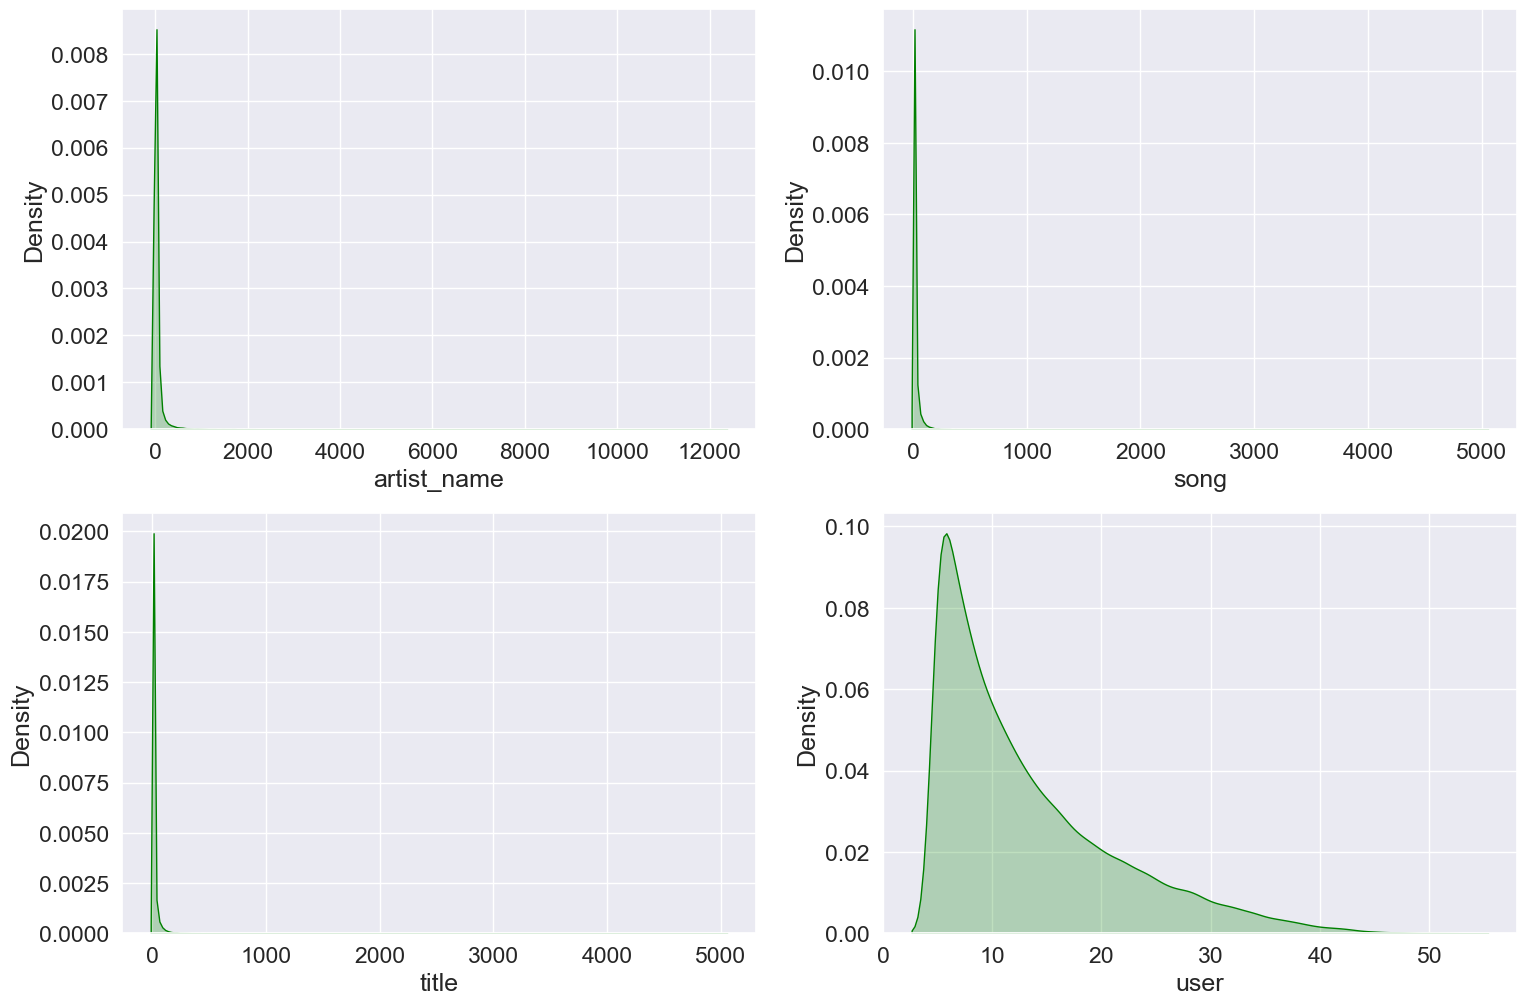

In [24]:
fig = plt.figure(figsize=(18, 12))

a1 = fig.add_subplot(221)
f1=sns.kdeplot(data=song_data,shade = True, color = 'green', x=song_data["artist_name"].value_counts())

a2 = fig.add_subplot(222)
f1=sns.kdeplot(data=song_data,shade = True, color = 'green', x=song_data["song"].value_counts())

a3 = fig.add_subplot(223)
f1=sns.kdeplot(data=song_data,shade = True, color = 'green', x=song_data["title"].value_counts())

a4 = fig.add_subplot(224)
f1=sns.kdeplot(data=song_data,shade = True, color = 'green',  x=song_data["user"].value_counts())



2.Triplet Data

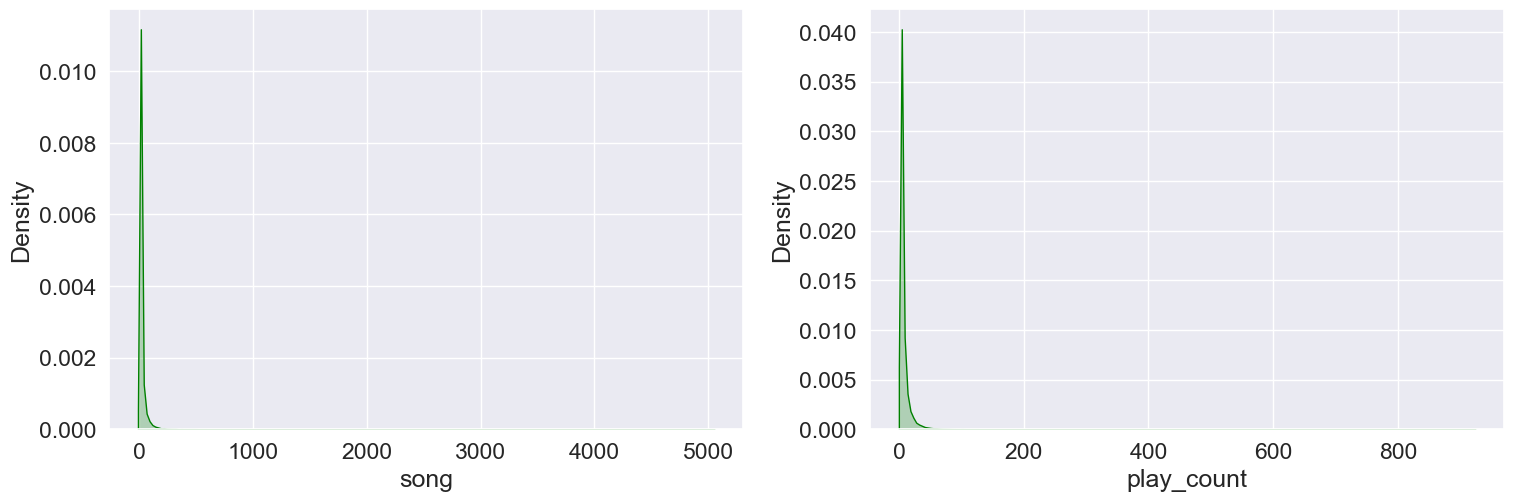

In [25]:
fig = plt.figure(figsize=(18, 12))

a1 = fig.add_subplot(221)
f1=sns.kdeplot(data=song_data,shade = True, color = 'green', x=song_data["song"].value_counts())

a2 = fig.add_subplot(222)
f1=sns.kdeplot(data=song_data, shade = True, color = 'green', x=song_data["play_count"])

### Lets describe the data

In [26]:
song_data.describe().T

,count,mean,std,min,25%,50%,75%,max
play_count,1450933.0,3.187149,7.051664,1.0,1.0,1.0,3.0,923.0


In [27]:
song_data.describe(include = "O").T

,count,unique,top,freq
track,1450933,163206,TRDMBIJ128F4290431,5043
user,1450933,110000,7d90be8dfdbde170f036ce8a4b915440137cb11c,53
song,1450933,163206,SOFRQTD12A81C233C0,5043
artist_name,1450933,28361,Coldplay,12279
title,1450932,137626,Sehr kosmisch,5043


#### Check missing values

In [28]:
print("Total Number of Null Value in data:", song_data.isnull().sum().sum())

Total Number of Null Value in data: 1


In [29]:
song_data.isnull().sum()

track          0
user           0
song           0
play_count     0
artist_name    0
title          1
dtype: int64

In [30]:
song_data.title.dtypes

dtype('O')

In [31]:
song_data["title"]

0                                             You're The One
1          Horn Concerto No. 4 in E flat K495: II. Romanc...
2                                                   Tive Sim
3          Catch You Baby (Steve Pitron & Max Sanna Radio...
4                                                El Cuatrero
                                 ...                        
1450928                                        Ms. Fat Booty
1450929                                     Ain't Misbehavin
1450930                                            Luvstruck
1450931                               Sinisten tÃ¤htien alla
1450932                                             The Gift
Name: title, Length: 1450933, dtype: object

In [32]:
 song_data["title"]=song_data["title"].fillna(song_data["title"].mode()[0])

In [33]:
print("Total Null Values in data after imputation:", song_data.isnull().sum().sum())

Total Null Values in data after imputation: 0


In [34]:
print('{:d} users, {:.2%} of total play counts, listening a single more than 200 times'.format(
    song_data.user[song_data.play_count>200].unique().shape[0],
    song_data.play_count[song_data.play_count>200].count()/song_data.shape[0]))
display(song_data.play_count[song_data.play_count>200].describe().reset_index().T)

138 users, 0.01% of total play counts, listening a single more than 200 times


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
play_count,154,286.188,102.503,201,221,250,310.25,923


So, as we can see only 138 users listen to a single song more than 200 times, but, would this be possible?

Let's consider that a song has 3:30 minutes in average and create it for the two most obsessed users and check out what their songs are:

In [35]:
lunatic = song_data.play_count[song_data.play_count>song_data.play_count.max()-10].values[0]
print('- How much days the most obsessed user can be the fan of a unique song: {:.1f}'.format((lunatic*3.5)/60/24))
display(song_data[song_data.song.isin(
                  song_data[song_data.play_count>song_data.play_count.max()-10].song.values)])

- How much days the most obsessed user can be the fan of a unique song: 2.2


,track,user,song,play_count,artist_name,title
1449167,TRXIHSR12903CC4FA5,22bb29714137fa47083963c30e1a26f1bf517e7d,SOXTUWG12AB018A2E2,923,Kilgore,Drop The Hammer (Album Version)


So we have to be careful when creating a recommendation system that can be affected by the outliers. Let's take a look at the top 20 in the different features we have:

In [36]:
song_data.play_count[song_data.play_count>song_data.play_count.max()-10].values[0]

923

In [37]:
(923*3.5)/60/24

2.243402777777778

creating new feature combining title and artist name
song_data['Song'] = song_data['title']+' - '+song_data['artist_name']
song_data.head()

### Analysis of Songs Id

In [38]:
#plt.rcParams["figure.figsize"] = (10,7)


#popular_songs[:20].plot(kind='barh', title='Top 20 Most Popular Songs', legend=False,)
#plt.xticks(rotation='vertical')
#plt.ylabel('Item count')


#plt.show()

In [39]:
#plt.rcParams["figure.figsize"] = (20,15)
#popular_song_singer = song_data[['Song','play_count']].groupby('Song').sum().\
                #sort_values('play_count', ascending=False).head(20).sort_values('play_count')
#popular_song_singer.plot(kind='barh', title='Top 20 Most Popular Song with Singer', legend=False,)
#plt.xticks(rotation='vertical')
#plt.ylabel('Item count')

#plt.show()

In [40]:
# cummulative sum of listen count of the songs Id

song_grouped = song_data.groupby(['song',]).agg({'play_count':'count'}).sort_values('play_count', ascending=False).reset_index()
song_grouped.head(10) 

,song,play_count
0,SOFRQTD12A81C233C0,5043
1,SOAUWYT12A81C206F1,4483
2,SOBONKR12A58A7A7E0,4136
3,SOAXGDH12A8C13F8A1,3780
4,SOSXLTC12AF72A7F54,3672
5,SONYKOW12AB01849C9,3430
6,SOEGIYH12A6D4FC0E3,3272
7,SODJWHY12A8C142CCE,2791
8,SOLFXKT12AB017E3E0,2725
9,SOFLJQZ12A6D4FADA6,2668


In [41]:
grouped_sum = song_grouped['play_count'].sum()
song_grouped['percentage']  = song_grouped['play_count'].div(grouped_sum)*100
song_grouped.sort_values(['play_count', 'song'], ascending = [0,1])

,song,play_count,percentage
0,SOFRQTD12A81C233C0,5043,0.347569
1,SOAUWYT12A81C206F1,4483,0.308974
2,SOBONKR12A58A7A7E0,4136,0.285058
3,SOAXGDH12A8C13F8A1,3780,0.260522
4,SOSXLTC12AF72A7F54,3672,0.253079
...,...,...,...
116089,SOZZYCA12AB0182579,1,0.000069
116096,SOZZZFM12AC4687A9E,1,0.000069
116097,SOZZZFW12AB0187AD1,1,0.000069
116098,SOZZZKJ12A6D4FBF66,1,0.000069


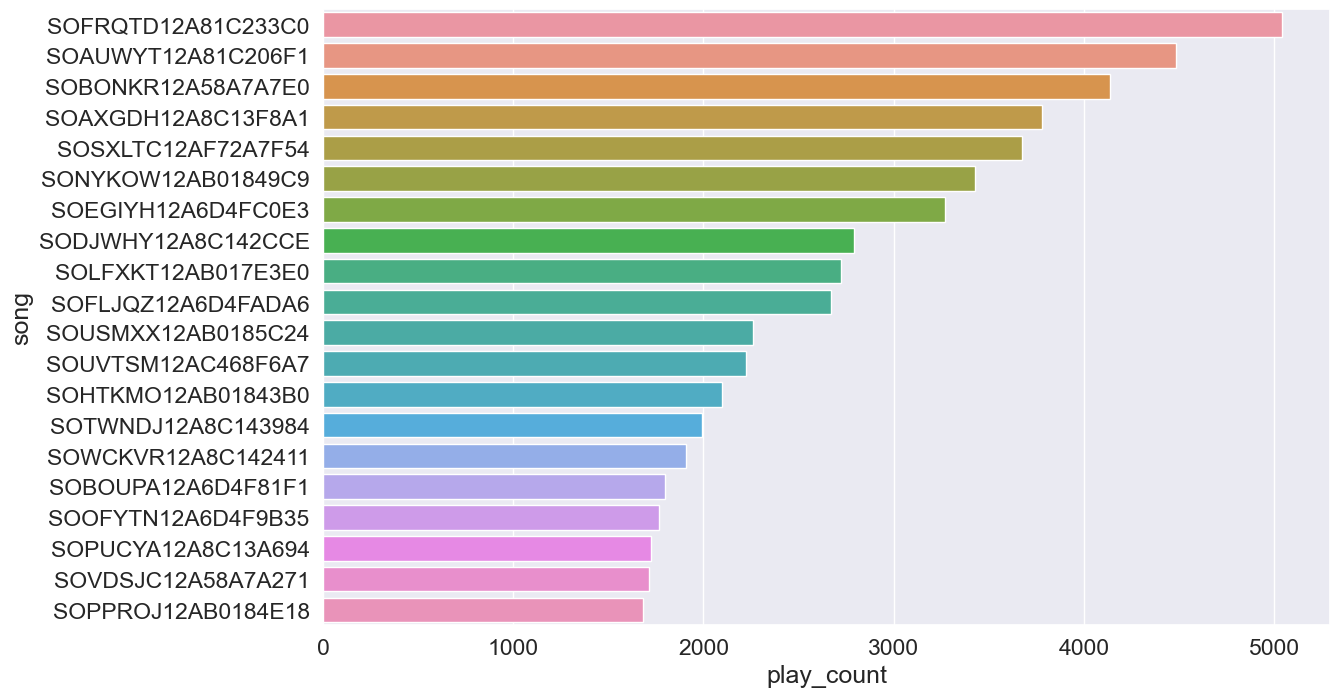

In [42]:
plt.figure(figsize = (13,8))
sns.barplot(y=song_grouped['song'][:20], x=song_grouped["play_count"])
plt.show()

## Analysis of Users

### Lets see how much time user listening a songs

In [43]:
song_per_user = song_data.groupby(['user',]).agg({'play_count':'count'}).sort_values('play_count', ascending=False).reset_index() 

In [44]:
song_per_user

,user,play_count
0,7d90be8dfdbde170f036ce8a4b915440137cb11c,53
1,d30e18323f15426c3cdc8585252ed34459916f51,52
2,03ad93fdb01506ce205f4708decf8e4b1ae90fff,52
3,2e424b28bff1f62a2dae22a918f09f9c30c06d1b,52
4,016a24e91a72c159a5048ab1b9b2ba5ce761b526,52
...,...,...
109995,dc14d67f7d79c2e54c5a220ceca3fea2baf8e0d3,5
109996,dc152fb9b0b72648dc10e6ed6effb3b148aa316a,5
109997,dc1b5222568cc291fe6bed8d6b37ce780ac661e5,5
109998,66bdee78bbcd7e82d359173ef801f5094b40a344,5


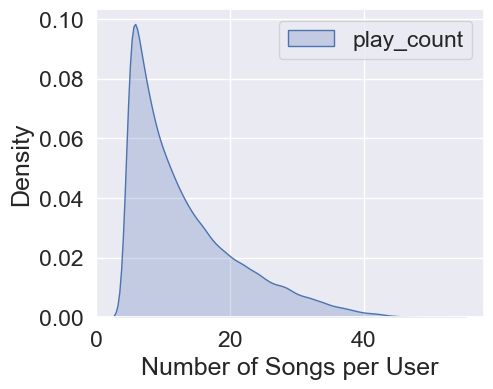

In [45]:
plt.figure(figsize = (5,4))
plt.xlabel("Number of Songs per User")

sns.kdeplot(data=song_per_user,shade = True, color = 'blue' )
plt.show()

In [46]:
song_data["user"].value_counts()[:5]

7d90be8dfdbde170f036ce8a4b915440137cb11c    53
03ad93fdb01506ce205f4708decf8e4b1ae90fff    52
d30e18323f15426c3cdc8585252ed34459916f51    52
2e424b28bff1f62a2dae22a918f09f9c30c06d1b    52
0f8308935bcbb9a1e04ebb7c4d41c037e5f23b90    52
Name: user, dtype: int64

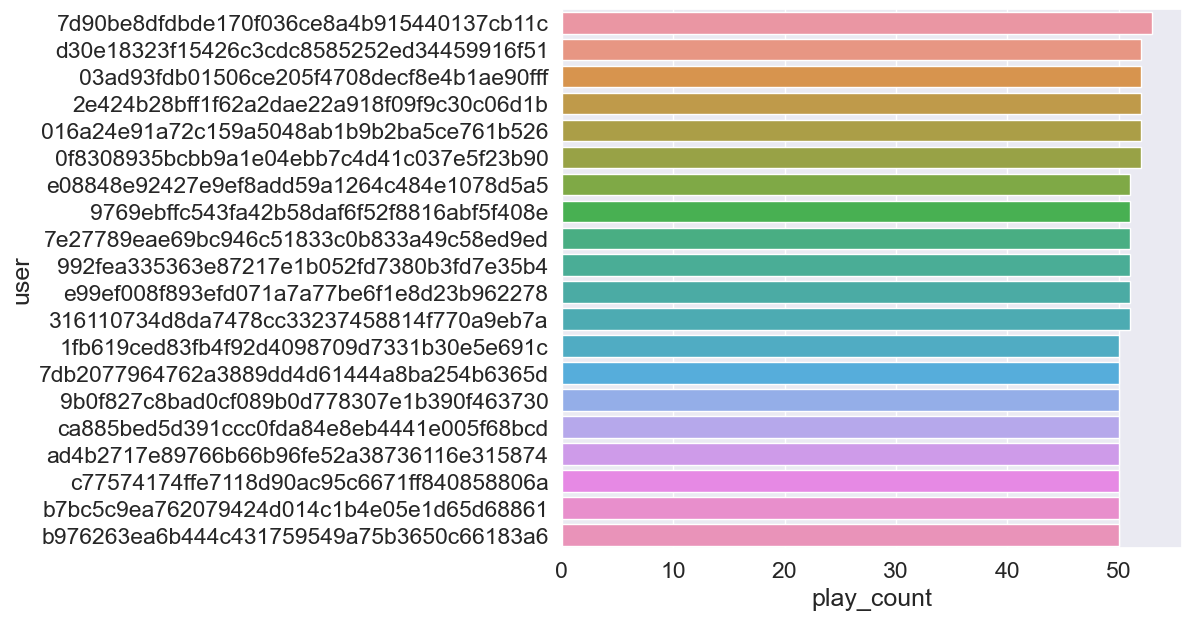

In [47]:
plt.figure(figsize = (8,7))
sns.barplot(y=song_per_user['user'][:20], x=song_per_user["play_count"])
plt.show()

## Analysis of Artist

### Popular Artist

In [48]:
popular_artist = song_data.groupby(['artist_name',]).agg({'play_count':'count'}).sort_values('play_count', ascending=False)
popular_artist.head(10)

,play_count
artist_name,
Coldplay,12279
Kings Of Leon,8514
Florence + The Machine,8213
Justin Bieber,7669
Jack Johnson,6784
Train,6617
The Black Keys,6507
Eminem,6297
OneRepublic,6027


In [49]:
#song_data[['Artist_Name','play_count']].groupby('Artist_Name').sum().sort_values('play_count', ascending=False)

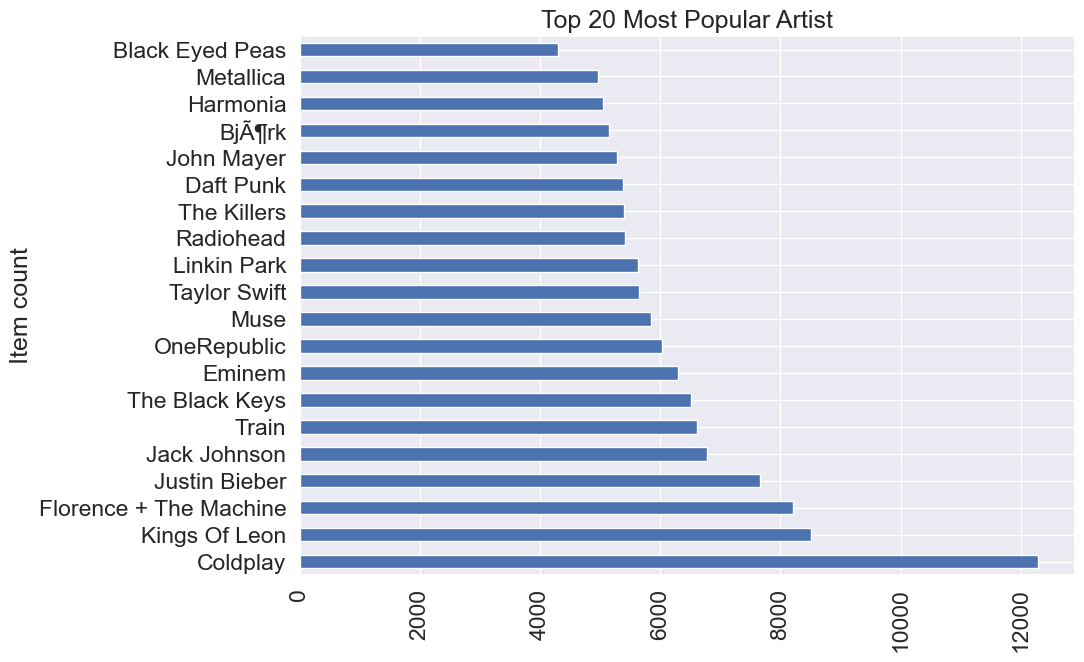

In [50]:
plt.rcParams["figure.figsize"] = (10,7)

popular_artist[:20].plot(kind='barh', title='Top 20 Most Popular Artist', legend=False,)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

plt.show()

In [51]:
#QQ_plot(song_data[song_data["title"]=="Coldplay"].play_count, 'Listen Most Popular Song')

## Analysis of songs

In [52]:
song_data["title"].value_counts()[:5]

Sehr kosmisch                     5044
Undo                              4483
You're The One                    4270
Dog Days Are Over (Radio Edit)    3780
Revelry                           3672
Name: title, dtype: int64

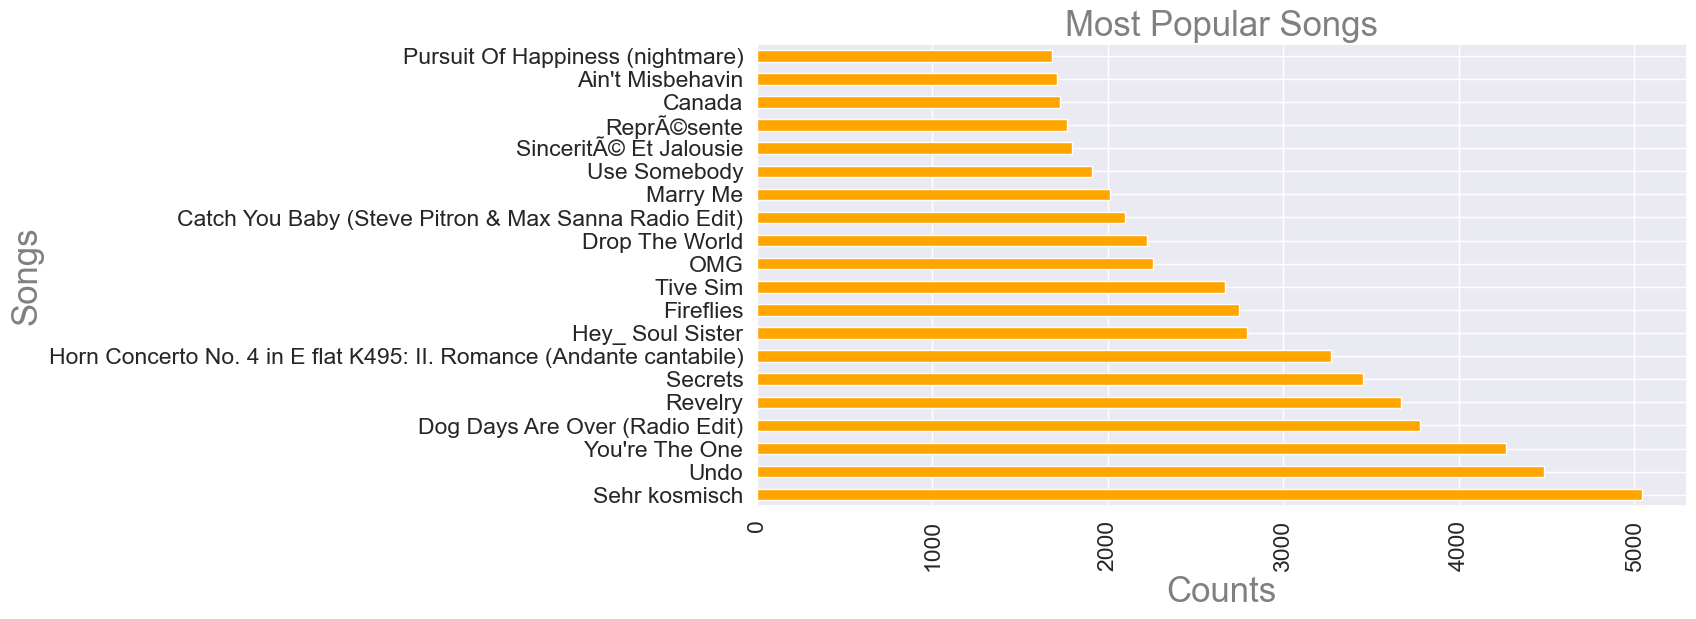

In [53]:
plt.figure(figsize = (12,6))
#song_data['title'].value_counts().head(20).plot.bar(kind='barh',color = 'orange')
song_data['title'].value_counts().head(20).plot(color = 'orange',kind='barh', title='Top 20 Most Popular Artist', legend=False,)
plt.title('Most Popular Songs',color = 'Grey',fontsize=25)
plt.xticks(rotation='vertical')
plt.xlabel('Counts',color = 'Grey',fontsize=25)
plt.ylabel('Songs',color = 'Grey',fontsize=25)
plt.show()

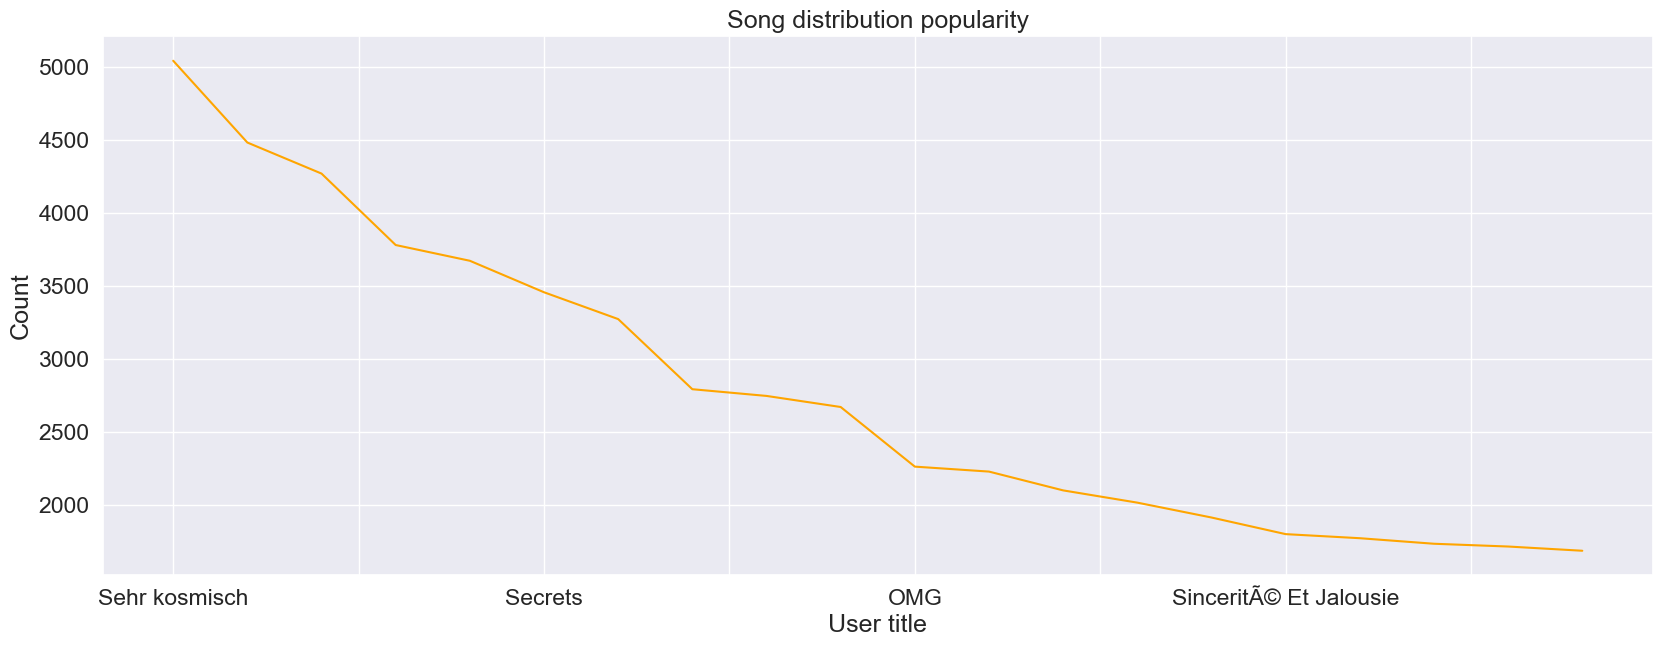

In [54]:
plt.figure(figsize = (20,7))
song_data['title'].value_counts().head(20).plot.line(color = 'orange')
plt.title('Song distribution popularity')
plt.xlabel('User title')
plt.ylabel('Count')
plt.show()

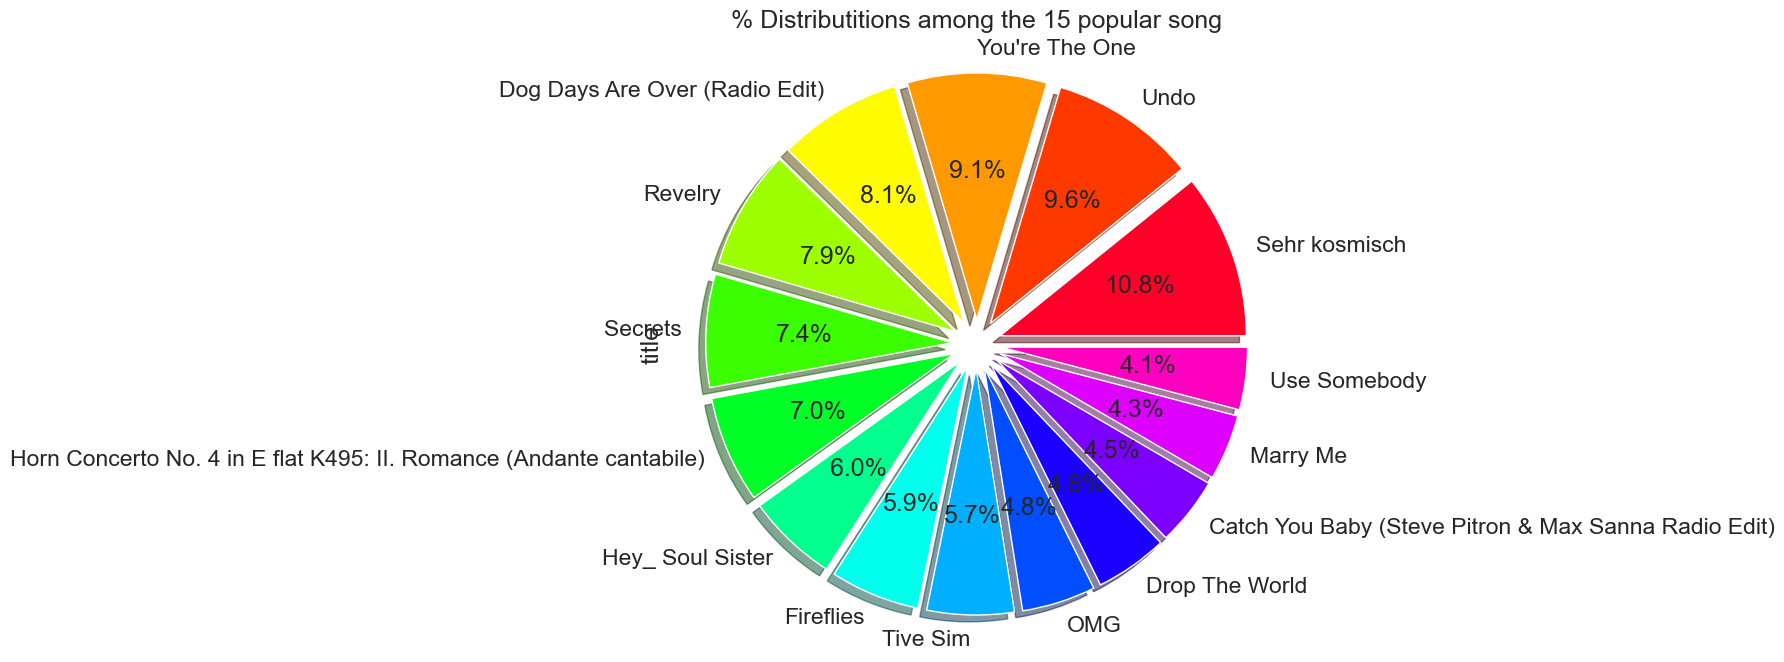

In [55]:
#plt.style.use('dark_background') 
plt.figure(figsize = (20,8))
song_data['title'].value_counts()[:15].plot.pie(explode=[0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1],autopct='%1.1f%%',shadow=True,cmap='gist_rainbow')
plt.title('% Distributitions among the 15 popular song')
plt.show()

#### So we have to be careful when creating a recommendation system that can be affected by the outliers. Let's take a look at the top 20 in the different features we have:

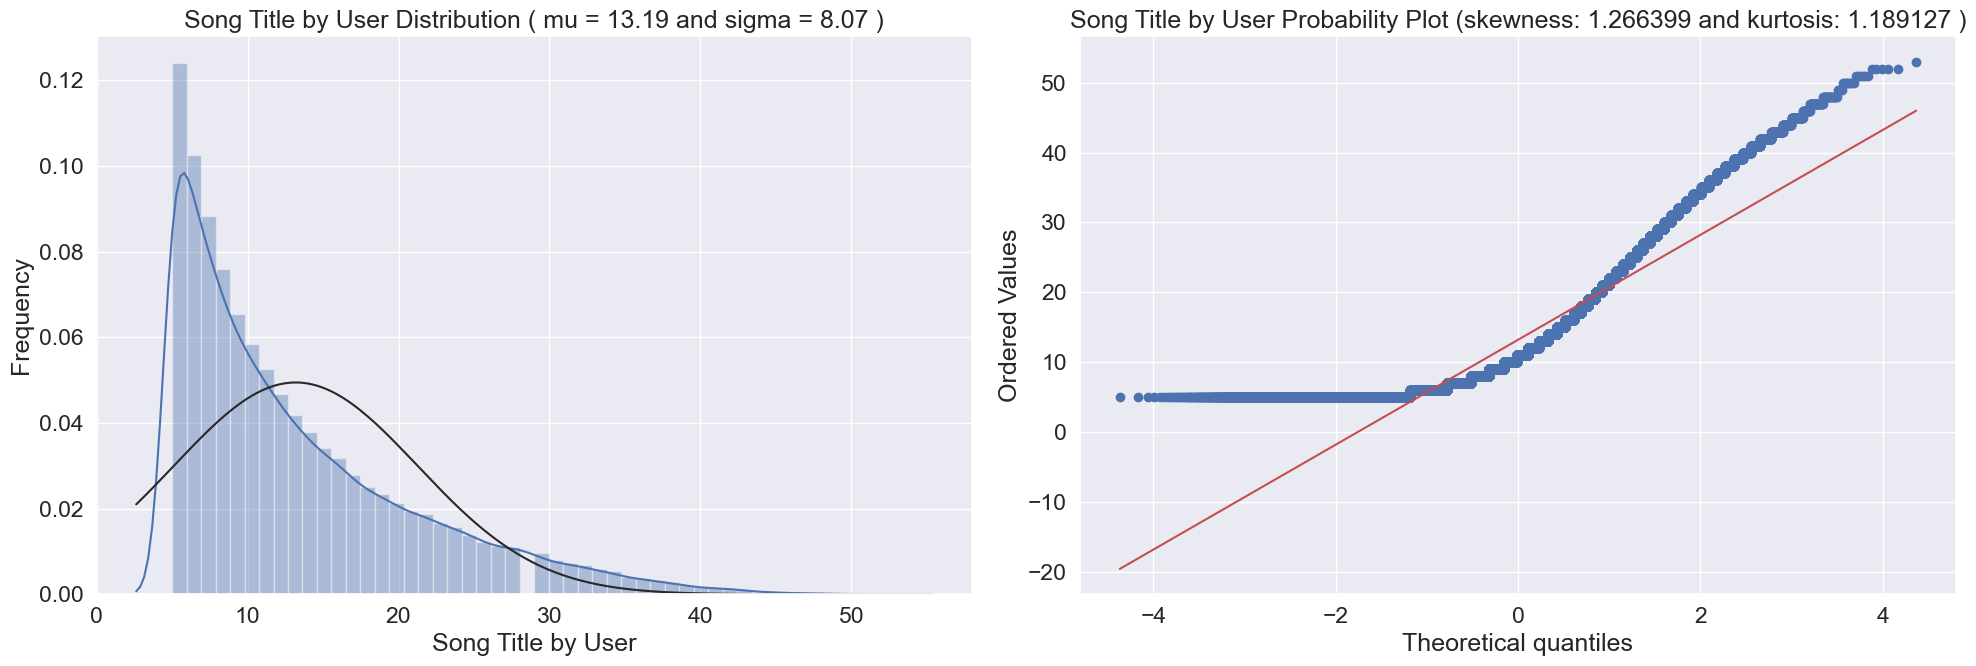

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
title,110000,13.1903,8.07083,5,7,11,17,53


In [56]:
user_song_count_distribution = song_data[['user','title']].groupby('user').count().\
                                reset_index().sort_values(by='title',ascending = False)

def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()
    
QQ_plot(user_song_count_distribution.title, 'Song Title by User')
user_song_count_distribution.title.describe().reset_index().T

From the first graph above we can see that song title by user distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is somewhat positively biased.

From the Probability Plot, we could see that song title by user also does not align with the diagonal red line which represent normal distribution. The form of its distribution confirm that is a skewed right.

With skewness positive of 1.26, we confirm the lack of symmetry and indicate that song title by user are skewed right, as we can see too at the song title by user distribution plot, skewed right means that the right tail is long relative to the left tail, as we expect in counts. The skewness for a normal distribution is zero, and any symmetric data should have a skewness near zero. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers, and positive kurtosis indicates a heavy-tailed distribution and negative kurtosis indicates a light tailed distribution. So, with 1.18 of positive kurtosis song title by user are acceptable, although we can accept the kurtosis within 3.

OK, let's take a look at the distribution of the number of times users heard the most popular song.

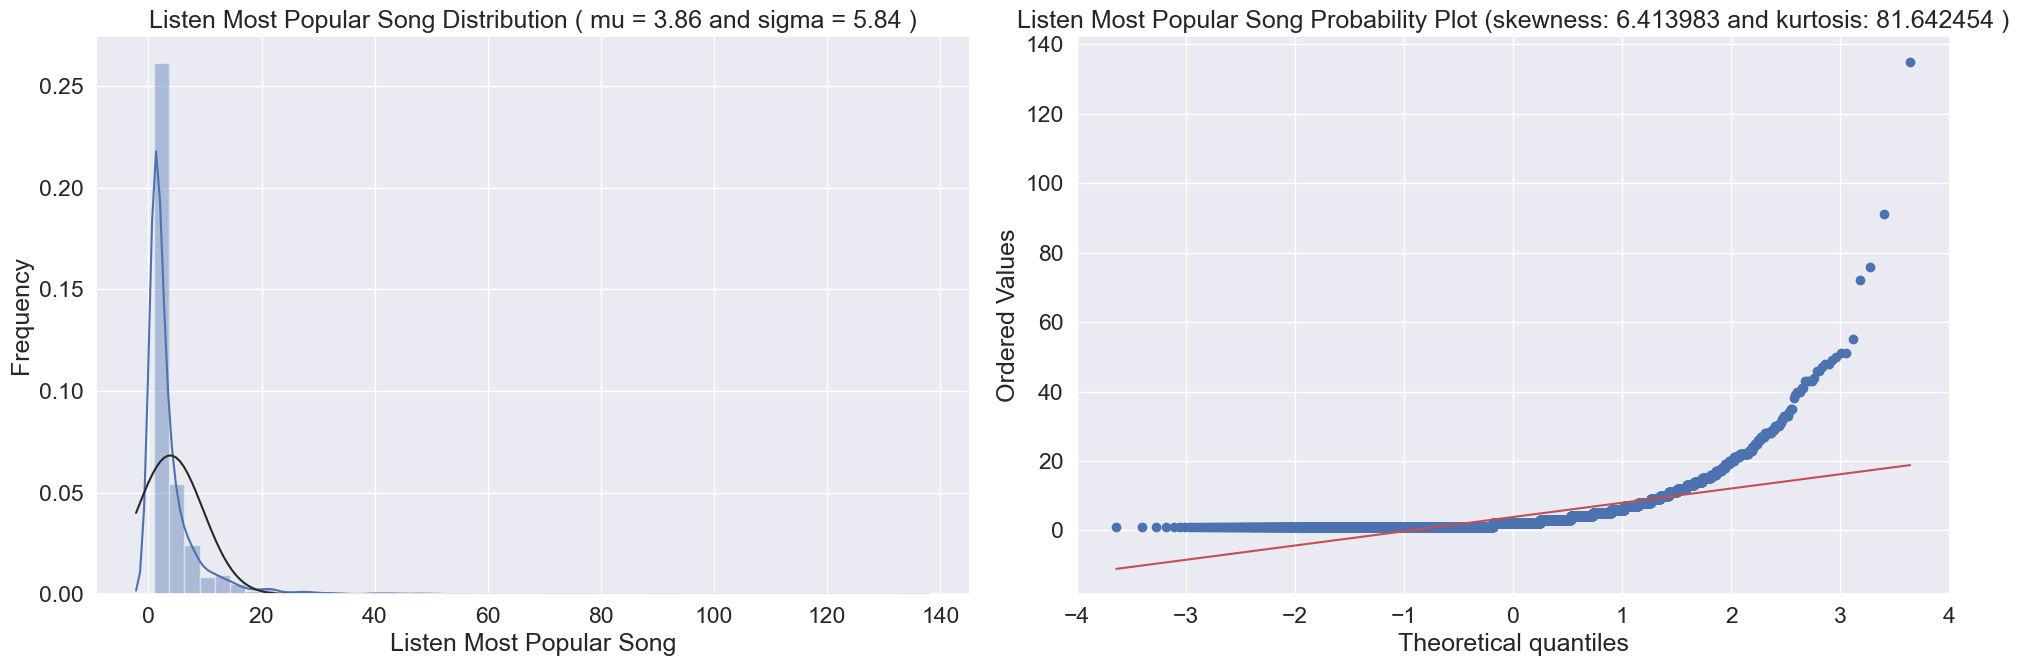

In [57]:
QQ_plot(song_data[song_data["title"]=="Sehr kosmisch"].play_count, 'Listen Most Popular Song')

In [58]:
song_data.head(2)

,track,user,song,play_count,artist_name,title
0,TRAEHHJ12903CF492F,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,Dwight Yoakam,You're The One
1,TRLGMFJ128F4217DBE,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...


In [59]:
data = song_data.copy()

In [60]:
bins = [0, 1, 5, 10, 25, 50, 100, 200, 400, 1000]
data['binned'] = pd.cut(data['play_count'], bins, 
                         labels=['1_time', '2-5_times', '6-10_times', '11-25_times', '26-50_times', '51-100_times',
                                '101-200_times', '201-400_times', '400+_times'])

In [61]:
data['binned'].value_counts()

1_time           839136
2-5_times        438138
6-10_times        97994
11-25_times       57890
26-50_times       13290
51-100_times       3559
101-200_times       772
201-400_times       136
400+_times           18
Name: binned, dtype: int64

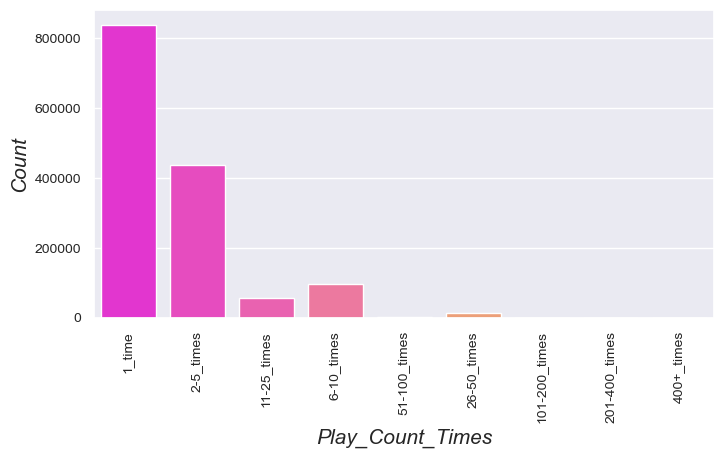

In [62]:
plt.figure(figsize=(8,4))
sns.countplot(data['binned'].astype('str'), data=data, palette='spring')
plt.xticks(fontsize=10)
plt.xticks(rotation=90)
plt.yticks(fontsize=10)
plt.xlabel('Play_Count_Times', fontsize=15, style='oblique')
plt.ylabel('Count', fontsize=15, style='oblique')
plt.show()

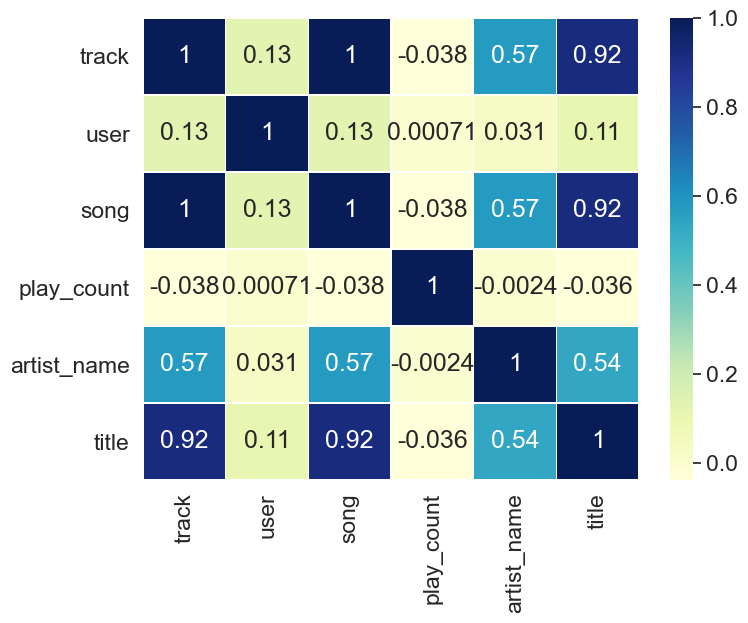

In [63]:
plt.figure(figsize=(8, 6))
mask = np.array(song_data.corr())
mask[np.tril_indices_from(mask)]=False
corr = song_data.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, annot=True,yticklabels=corr.columns, 
                 linewidths=.2,cmap="YlGnBu")

In [64]:
song_data.to_csv('song_data.csv',index=False)